In [1]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import NeuralTrajectory, SpikeTrain
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap
from mazepy.basic._time_sync import _coordinate_recording_time

code_id = "0855 - Mapping Initialization Phase"
loc = os.path.join(figpath, "Dsp", code_id)
mkdir(loc)

import scipy.stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

dir_name1 = join(figpath, "Dsp", "0850 - Lisa Paper Revisits")
dir_name0 = join(figpath, "Dsp", "0844 - Manifold of Initialization")

def get_neural_traj(trace: dict):    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx, end_idx = LapSplit(trace, trace['paradigm'])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    
    neural_trajs = []
    pos_trajs = []
    time_trajs = []
    cumlen_trajs = []
    route_trajs = []
    lap_trajs = []
    speed_trajs = []
    perfect_trajs = []
    
    for i in tqdm(range(beg_idx.shape[0])):
        if trace['is_perfect'][i] != 1 and routes[i] == 0:
            continue
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        dx = np.ediff1d(trace['correct_pos'][beg_idx[i]:end_idx[i], 0])/10
        dy = np.ediff1d(trace['correct_pos'][beg_idx[i]:end_idx[i], 1])/10
        dis = np.sqrt(dx**2+dy**2)
        dt = np.ediff1d(trace['correct_time'][beg_idx[i]:end_idx[i]])
        cumdis = np.cumsum(dis)
        
        speed = np.sqrt(dx**2+dy**2) / dt * 1000
        speed = np.convolve(speed, np.ones(3)/3, mode='same')
        cumt = trace['correct_time'][beg_idx[i]:end_idx[i]-1]
        spike_nodes = trace['spike_nodes_original'][spike_idx].astype(np.int64)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        neural_traj = spike_train.calc_neural_trajectory(500, 100)
        neural_traj_vec = neural_traj.to_array()
        pos_traj = neural_traj.variable.to_array()
        time_traj = neural_traj.time
        idx = _coordinate_recording_time(time_traj.astype(np.float64), cumt.astype(np.float64))
        
        neural_trajs.append(neural_traj_vec)
        pos_trajs.append(pos_traj)
        time_trajs.append(time_traj - trace['ms_time'][spike_idx[0]])
        speed_trajs.append(speed[idx])
        cumlen_trajs.append(cumdis[idx])
        
        route_trajs.append(np.repeat(routes[i], neural_traj_vec.shape[1]).astype(np.int64))
        lap_trajs.append(np.repeat(i, neural_traj_vec.shape[1]).astype(np.int64))
        perfect_trajs.append(np.repeat(int(trace['is_perfect'][i]), neural_traj_vec.shape[1]))
    
    return (
        np.concatenate(neural_trajs, axis=1), 
        np.concatenate(pos_trajs), 
        np.concatenate(time_trajs),
        np.concatenate(route_trajs), 
        np.concatenate(lap_trajs), 
        np.concatenate(speed_trajs),
        np.concatenate(cumlen_trajs),
        np.concatenate(perfect_trajs)
    )

        E:\Data\FinalResults\Dsp\0855 - Mapping Initialization Phase is already existed!


        E:\Data\FinalResults\Dsp\0855 - Mapping Initialization Phase\Mapping Data is already existed!


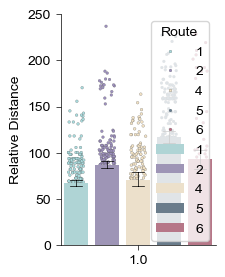

F_onewayResult(statistic=69.02096908633439, pvalue=1.0593286850094985e-40)
F_onewayResult(statistic=12.406558540155114, pvalue=5.630910472678063e-08)
Route 2:
  Mean: 67.64366951395196, STD: 27.218317902915395, Max: 170.55760828260742, Min: 3.3576742332888765, Median: 60.54119279504615, df: 263

Route 3:
  Mean: 87.23769497864889, STD: 31.581791421874165, Max: 237.00603110716355, Min: 7.5079878319334155, Median: 82.71182248480802, df: 258

Route 5:
  Mean: 70.52914313275089, STD: 54.983842182169425, Max: 810.9579775568117, Min: 7.5079878319334155, Median: 59.56921537259131, df: 253

Route 6:
  Mean: 116.9974721950917, STD: 55.18459130143939, Max: 490.3010146892246, Min: 39.83955493520736, Median: 113.4108354990649, df: 264

Route 7:
  Mean: 92.86503348586582, STD: 49.62889441290053, Max: 228.73777651276157, Min: 49.78081920660259, Median: 73.79278115326709, df: 84



(-0.4, 4.4)

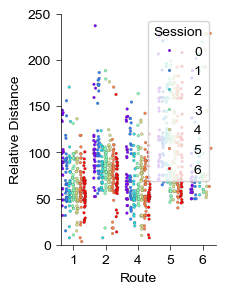

In [2]:
@jit(nopython=True)
def _calc_shortest_idx(src_neural_traj, targ_neural_traj):
    idx = np.zeros(src_neural_traj.shape[1], dtype=np.int64)
    val = np.zeros(src_neural_traj.shape[1])
    for i in range(src_neural_traj.shape[1]):
        corrs = np.zeros(targ_neural_traj.shape[1])
        for j in range(targ_neural_traj.shape[1]):
            corrs[j] = np.corrcoef(src_neural_traj[:, i], targ_neural_traj[:, j])[0, 1]
        
        corrs[np.where(np.isnan(corrs))[0]] = -1
        idx[i] = np.argmax(corrs)
        val[i] = np.max(corrs)
    return idx, val

def mapping_neural_activity(mouse, route: int, targ_route=0, session = 6):
    """
    Decode position from neural trajectory.
    
    Parameters
    ----------
    mouse: int
        Mouse ID
    route: int
        The route to be decoded
    targ_route: int
        Target Route, by default 0
    session: int
        The session to be decoded
        
    Returns
    -------
    The corresponding positions on route 1.
    (Route 1 shape, ), (Route n shape, ), (Route n shape, ), (
        (n_neuron, Route n shape), 
        (Route n shape, ), 
        (Route n shape, ), 
        (Route n shape, ), 
        (Route n shape, ), 
        (Route n shape, ),
        (Route n shape, )
    )
    """
    idx = np.where(f2['MiceID'] == mouse)[0][session]
    with open(f2['Trace File'][idx], 'rb') as handle:
        trace = pickle.load(handle)

    (
        neural_traj,
        pos_traj,
        time_traj,
        route_traj,
        lap_traj,
        speed_traj,
        len_traj,
        perfect_traj
    ) = get_neural_traj(trace)
    session_traj = np.repeat(session, neural_traj.shape[1])
    
    targ_idx = np.where(route_traj == targ_route)[0]
    targ_neural_traj = neural_traj[:, targ_idx]
    targ_pos_traj = pos_traj[targ_idx]
    targ_speed_traj = speed_traj[targ_idx]
    
    src_idx = np.where(route_traj == route)[0]
    src_neural_traj = neural_traj[:, src_idx]
    
    src_to_targ_idx, corr_val = _calc_shortest_idx(src_neural_traj, targ_neural_traj)
    
    src_pos_traj_mapped = targ_pos_traj[src_to_targ_idx]
    
    return targ_pos_traj, targ_speed_traj, src_to_targ_idx, corr_val, (
        src_neural_traj, 
        pos_traj[src_idx],
        time_traj[src_idx],
        lap_traj[src_idx],
        speed_traj[src_idx],
        len_traj[src_idx],
        perfect_traj[src_idx]
    )
    
def process_(mouse, route, session, loss_thre: float = 10, corr_thre = 0.3):
    print(f"Start Mapping Neural Activity for {mouse}, Route {route}, S{session}. ~ 30s required.")
    t0 = time.time()
    (
        targ_pos_traj, 
        targ_speed_traj,
        idx, 
        corr_val, 
        (
            src_neural_traj,
            src_pos_traj,
            src_time_traj,
            src_lap_traj,
            src_speed_traj,
            src_len_traj,
            src_perfect_traj
        )
    ) = mapping_neural_activity(mouse, route, session=session)
    print(f"  {time.time()-t0:.3f}s used. Start Visualization.\n")
    
    with open(f2['Trace File'][np.where(f2['MiceID'] == mouse)[0][session]], 'rb') as handle:
        trace = pickle.load(handle)
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    
    D = GetDMatrices(1, 48)
    loss = np.array([D[src_pos_traj[i], targ_pos_traj[idx][i]] for i in range(src_pos_traj.shape[0])])
    
    beg = np.concatenate([[0], np.where(np.ediff1d(src_lap_traj)!=0)[0]+1])
    end = np.concatenate([beg[1:], [src_lap_traj.shape[0]]])
    
    speed = np.zeros(beg.shape[0]) * np.nan
    corr = np.zeros(beg.shape[0]) * np.nan
    distances = np.zeros(beg.shape[0]) * np.nan
    times = np.zeros(beg.shape[0]) * np.nan
    lap = np.zeros(beg.shape[0]) * np.nan
    
    pos = []
    
    overal_time_traj = cp.deepcopy(src_time_traj)
    
    for i in range(len(beg)):
        overal_time_traj[beg[i]:end[i]] += beg_time[src_lap_traj[beg[i]]]
        loss[beg[i]:end[i]] = np.convolve(loss[beg[i]:end[i]], np.ones(10)/10, 'same')
        
        _converge_idx = np.where(
            (loss[beg[i]:end[i]] <= loss_thre) &
            (corr_val[beg[i]:end[i]] >= corr_thre)
        )[0]
        
        if _converge_idx.shape[0] < 1:
            speed[i], corr[i], distances[i] = np.nan, np.nan, np.nan
            times[i] = np.nan
            lap[i] = np.nan
            pos.append(np.array([]))
            continue
                
        # Whenever 10 continue point satisfy the criteria, we identify that the map is converged.
        #is_converge = False
        #init_pos = _converge_idx[0]
        #for j in range(len(_converge_idx) < 10):
            #if _converge_idx[j] + 9 == _converge_idx[j+9]:
            #    init_pos = _converge_idx[j]
        is_converge = True
                #break
        init_pos = _converge_idx[0]
        
        if is_converge:
            speed[i] = src_speed_traj[beg[i] + init_pos]
            corr[i] = corr_val[beg[i] + init_pos]
            distances[i] = D[src_pos_traj[beg[i] + init_pos], SP_DSP[route]-1]
            times[i] = 0.5 + 0.1*init_pos
            lap[i] = src_lap_traj[beg[i]]
            pos.append(targ_pos_traj[idx][beg[i]:beg[i] + init_pos])
        else:
            speed[i], corr[i], distances[i] = np.nan, np.nan, np.nan
            times[i] = np.nan
            lap[i] = np.nan
            pos.append(np.array([]))
        
    if len(pos) >= 2:
        pos = np.concatenate(pos)
    elif len(pos) == 1:
        pos = pos[0]
    else:
        pos = np.array([])
        
    pos = pos[np.where(np.isnan(pos) == False)[0]].astype(np.int64)
    
    rates_count2 = scipy.stats.binned_statistic(
        S2F[pos],
        np.ones(pos.shape[0]),
        statistic='sum',
        bins=144,
        range=[0, 144+1e-8]
    )[0]
    bg_count2 = scipy.stats.binned_statistic(
        S2F[targ_pos_traj],
        np.ones(targ_pos_traj.shape[0]),
        statistic='count',
        bins=144,
        range=[0, 144+1e-8]
    )[0]
    bg_count2[bg_count2 == 0] = 1e-8
    rate2s = rates_count2 / bg_count2
    
    save_data = {
        "neural_traj": src_neural_traj,
        "pos_traj": src_pos_traj,
        "route_traj": np.repeat(route, src_pos_traj.shape[0]),
        "session_traj": np.repeat(session, src_pos_traj.shape[0]),
        "time_traj": src_time_traj,
        "lap_traj": src_lap_traj,
        "speed_traj": src_speed_traj,
        "len_traj": src_len_traj,
        "perfect_traj": src_perfect_traj,
        
        "speed": speed,
        "corr": corr,
        "distances": distances,
        "pos": pos,
        "times": times,
        "lap": lap,
        
        "targ_pos_traj": targ_pos_traj,
        "targ_speed_traj": targ_speed_traj,
        "idx": idx,
        "corr_val": corr_val,
        "corr_thre": corr_thre,
        "loss_thre": loss_thre,
        "loss": loss,
        "time": overal_time_traj,
        "x_true": D[src_pos_traj, 0] / (np.max(D) + 1e-8) * 111,
        "x_pred": D[targ_pos_traj[idx], 0] / (np.max(D) + 1e-8) * 111,
        "error_mapping_distribution": rate2s
    }
    
    return speed, corr, distances, pos, times, lap, save_data

mkdir(join(loc, "Mapping Data"))
if exists(join(figdata, f"{code_id}.pkl")) == False:
    Data = {
        "MiceID":[],
        "Session": [],
        "Route": [],
        "Corr": [],
        "Relative Distance": [],
        "Speed": [],
        "Time": [],
        "Lap": []
    }
    
    PriorInitData = {
        "MiceID":[],
        "Session": [],
        "Route": [],
        "Position": []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        for route in range(1, 7):
            for session in range(7):

                speed, corr, distances, pos, times, lap, save_data = process_(mouse, route, session=session)
                
                perfect_idx = np.where(lap >= 0)[0]
                Data['MiceID'].append(np.repeat(mouse, perfect_idx.shape[0]))
                Data['Session'].append(np.repeat(session, perfect_idx.shape[0]))
                Data['Route'].append(np.repeat(route, perfect_idx.shape[0]))
                Data['Corr'].append(corr[perfect_idx])
                Data['Relative Distance'].append(distances[perfect_idx])
                Data['Speed'].append(speed[perfect_idx])
                Data['Time'].append(times[perfect_idx])
                Data['Lap'].append(lap[perfect_idx])
                
                PriorInitData['MiceID'].append(np.repeat(mouse, pos.shape[0]))
                PriorInitData['Session'].append(np.repeat(session, pos.shape[0]))
                PriorInitData['Route'].append(np.repeat(route, pos.shape[0]))
                PriorInitData['Position'].append(pos)
                
                with open(join(loc, "Mapping Data", f"{mouse} R{route} S{session}.pkl"), 'wb') as f:
                    pickle.dump(save_data, f)
                    
    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
        
    for k in PriorInitData.keys():
        PriorInitData[k] = np.concatenate(PriorInitData[k])
        
    print(Data['Corr'].shape[0], PriorInitData['Position'].shape)
    
    with open(join(figdata, f"{code_id}.pkl"), 'wb') as f:
        pickle.dump(Data, f)
    
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, f"{code_id}.xlsx"), index=False)
        
    with open(join(figdata, f"{code_id} [Pos].pkl"), 'wb') as f:
        pickle.dump(PriorInitData, f)
    
    PriorInitD = pd.DataFrame(PriorInitData)
    PriorInitD.to_excel(join(figdata, f"{code_id} [Pos].xlsx"), index=False)
    D = GetDMatrices(1, 48)
    Data["Relative Distance"] = Data["Relative Distance"] / (np.max(D) + 1e-8) * 888

else:
    with open(join(figdata, f"{code_id}.pkl"), 'rb') as handle:
        Data = pickle.load(handle)
        
    with open(join(figdata, f"{code_id} [Pos].pkl"), 'rb') as f:
        PriorInitData = pickle.load(f)
    
    D = GetDMatrices(1, 48)
    Data["Relative Distance"] = Data["Relative Distance"] / (np.max(D) + 1e-8) * 888

idx = np.where(np.isin(Data['Route'], [1, 2, 4, 5, 6]))[0]
SubData = SubDict(Data, Data.keys(), idx)
fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(
    plt.axes(), 
    close_spines=['top', 'right'], 
    ifxticks=True, ifyticks=True
)
sns.stripplot(
    x=np.ones(SubData['Route'].shape[0]),
    y="Relative Distance",
    data=SubData,
    hue="Route",
    palette=[DSPPalette[i] for i in [1, 2, 4, 5, 6]],
    size=2, 
    linewidth=0.15,
    dodge=True,
    jitter=0.2,
    zorder=1
)

sns.barplot(
    x=np.ones(SubData['Route'].shape[0]),
    y="Relative Distance",
    data=SubData,
    hue="Route",
    palette=[DSPPalette[i] for i in [1, 2, 4, 5, 6]],
    err_kws={"linewidth": 0.5, "color": "k"},
    capsize=0.3,
    zorder=2,
    gap=0.2
)

ax.set_ylim(-0, 250)
ax.set_xlim(-0.4, 0.4)
plt.savefig(join(loc, "Relative Distances.png"), dpi=600)
plt.savefig(join(loc, "Relative Distances.svg"), dpi=600)
plt.show()

print(f_oneway(*[SubData['Relative Distance'][
    (SubData['Route'] == i)&(np.isnan(SubData['Relative Distance']) == False)
    ] for i in [1, 2, 4, 5]
]))
print(f_oneway(*[SubData['Speed'][
    (SubData['Route'] == i)&(np.isnan(SubData['Speed']) == False)
    ] for i in [1, 2, 4, 5]                                       
]))

for route in [1, 2, 4, 5, 6]:
    idx = np.where(
        (SubData['Route'] == route)
    )[0]
    print(f"Route {route+1}:")
    print_estimator(SubData['Relative Distance'][idx], end='\n\n')
    
fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(
    plt.axes(), 
    close_spines=['top', 'right'], 
    ifxticks=True, 
    ifyticks=True
)

sns.stripplot(
    x='Route',
    y='Relative Distance',
    data=SubData,
    hue='Session',
    palette='rainbow',    
    size=2, 
    linewidth=0.15,
    dodge=True,
    jitter=0.2,
    zorder=1,
    ax=ax
)
ax.set_ylim(-0, 250)
ax.set_xlim(-0.4, 4.4)

# Decoding Retrieval Moment

        E:\Data\FinalResults\Dsp\0855 - Mapping Initialization Phase\Lapwise Decode\10232 S0 is already existed!
10232 R1 S0 Lap 19


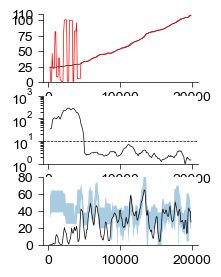

        E:\Data\FinalResults\Dsp\0855 - Mapping Initialization Phase\Lapwise Decode\10232 S0 is already existed!
        E:\Data\FinalResults\Dsp\0855 - Mapping Initialization Phase\Lapwise Decode\10232 S0 is already existed!
10232 R3 S0 Lap 36


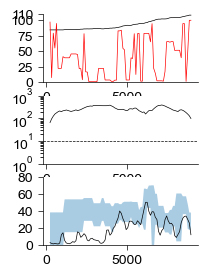

        E:\Data\FinalResults\Dsp\0855 - Mapping Initialization Phase\Lapwise Decode\10232 S0 is already existed!
        E:\Data\FinalResults\Dsp\0855 - Mapping Initialization Phase\Lapwise Decode\10232 S0 is already existed!
        E:\Data\FinalResults\Dsp\0855 - Mapping Initialization Phase\Lapwise Decode\10232 S0 is already existed!


In [3]:
for mouse in [10232]:
    for route in range(1, 7):
        for session in range(1):
            save_dir = join(loc, "Lapwise Decode", f"{mouse} S{session}")
            mkdir(save_dir)
            with open(join(loc, "Mapping Data", f"{mouse} R{route} S{session}.pkl"), 'rb') as f:
                saved_data = pickle.load(f)
                
            targ_pos_old = S2F[saved_data['targ_pos_traj']]-1
            speed_thre = np.zeros((144, 4))
            for i in range(144):
                idx = np.where(targ_pos_old == i)[0]
                if idx.shape[0] < 5:
                    speed_thre[i, :] = np.nan
                else:
                    mu, sigma = norm.fit(saved_data['targ_speed_traj'][idx])
                    lower, upper = norm.ppf([0.025, 0.975], loc=mu, scale=sigma)
                    speed_thre[i, :] = np.array([lower, mu, upper, sigma])
            
            idx = np.where(np.isin(
                saved_data['route_traj'], [1, 2, 3, 4, 5, 6]
            ))[0]
                
            for l in np.unique(saved_data['lap_traj']):
                
                if l not in [19, 36]:
                    continue

                print(f"{mouse} R{route} S{session} Lap {l}")
                idx = np.where(saved_data['lap_traj'] == l)[0]
                t, x_true, x_pred, loss, speed, pos = (
                    saved_data['time_traj'][idx],
                    saved_data['x_true'][idx],
                    saved_data['x_pred'][idx],
                    saved_data['loss'][idx],
                    saved_data['speed_traj'][idx],
                    S2F[saved_data['pos_traj'][idx]]-1
                )
                ctrl_speed = speed_thre[pos, :]

                
                fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(2, 3))
                ax1 = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
                ax1.plot(
                    t,
                    x_true,
                    linewidth=0.5,
                    color='k'
                )
                ax1.plot(
                    t,
                    x_pred,
                    linewidth=0.5,
                    color='red'
                )
                ax1.set_ylim(0, 110)
                ax1.set_yticks([0, 25, 50, 75, 100, 110])
                
                ax2 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
                ax2.plot(
                    t,
                    loss,
                    linewidth=0.5,
                    color='k'
                )
                ax2.axhline(10, color='k', linewidth=0.5, ls='--')
                ax2.semilogy()
                ax2.set_ylim(1, 1000)
                
                ax3 = Clear_Axes(axes[2], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
                ax3.plot(
                    t,
                    speed,
                    linewidth=0.5,
                    color='k'
                )
                ax3.fill_between(
                    t, 
                    y1=ctrl_speed[:, 0],
                    y2=ctrl_speed[:, 2],
                    edgecolor=None,
                    facecolor=DSPPalette[0]
                )
                ax3.set_ylim(0, 80)
                ax3.set_yticks([0, 20, 40, 60, 80])
                plt.savefig(join(loc, f"Decoding Example-{mouse}-R{route}-S{session}-Lap{l}.png"), dpi=600)
                plt.savefig(join(loc, f"Decoding Example-{mouse}-R{route}-S{session}-Lap{l}.svg"), dpi=600)
                #plt.savefig(join(save_dir, f"R{route}-Lap{l}.png"), dpi=600)
                #plt.savefig(join(save_dir, f"R{route}-Lap{l}.svg"), dpi=600)
                plt.show()

# Decoding Loss and Speed

        E:\Data\FinalResults\Dsp\0855 - Mapping Initialization Phase\Loss vs. Speed is already existed!


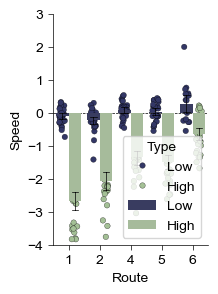

Route 2:
Low vs. 0: TtestResult(statistic=-2.2338195136354755, pvalue=0.03397431080304532, df=27)
Hig vs. 0: TtestResult(statistic=-19.525670297399063, pvalue=1.8703489776182108e-17, df=27)
Low vs. High: Ttest_indResult(statistic=17.72139215374145, pvalue=3.648231724210793e-24)

Route 3:
Low vs. 0: TtestResult(statistic=-3.5327354278191248, pvalue=0.0015014725414340322, df=27)
Hig vs. 0: TtestResult(statistic=-14.756285622362427, pvalue=1.911985075661444e-14, df=27)
Low vs. High: Ttest_indResult(statistic=11.952226819649375, pvalue=8.572480329918183e-17)

Route 5:
Low vs. 0: TtestResult(statistic=1.7147649511533773, pvalue=0.09784619083187152, df=27)
Hig vs. 0: TtestResult(statistic=-12.812798835908419, pvalue=5.459854534686289e-13, df=27)
Low vs. High: Ttest_indResult(statistic=12.399078447418272, pvalue=1.9868509781102417e-17)

Route 6:
Low vs. 0: TtestResult(statistic=0.4965913117652718, pvalue=0.6234964082386139, df=27)
Hig vs. 0: TtestResult(statistic=-13.148627261090837, pvalue=2

In [4]:
def get_speed_thre(mouse):
    pos = []
    speed = []
    
    for session in range(7):
        with open(join(loc, "Mapping Data", f"{mouse} R1 S{session}.pkl"), 'rb') as f:
            saved_data = pickle.load(f)
            pos.append(saved_data['targ_pos_traj'])
            speed.append(saved_data['targ_speed_traj'])
    
    pos = np.concatenate(pos)
    speed = np.concatenate(speed)
    idx = np.where((np.isnan(pos) == False)&(np.isnan(speed) == False))[0]
    pos = pos[idx]
    speed = speed[idx]
          
    targ_pos_old = S2F[pos]-1
    speed_thre = np.zeros((144, 4))
    for i in range(144):
        idx = np.where(targ_pos_old == i)[0]
        if idx.shape[0] < 0:
            speed_thre[i, :] = np.nan
        else:
            mu, sigma = norm.fit(speed[idx])
            lower, upper = norm.ppf([0.025, 0.975], loc=mu, scale=sigma)
            speed_thre[i, :] = np.array([lower, mu, upper, sigma])
    
    return speed_thre
                    
save_dir = join(loc, "Loss vs. Speed")
mkdir(save_dir)
if not os.path.exists(join(figdata, f"{code_id} [Loss vs. Speed].pkl")):
    LSData = {
        "MiceID": [],
        "Route": [],
        "Session": [],
        "Loss": [],
        "Speed": [],
        "Type": []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        speed_thre = get_speed_thre(mouse)
        for route in range(1, 7):
            for session in range(7):
                with open(join(loc, "Mapping Data", f"{mouse} R{route} S{session}.pkl"), 'rb') as f:
                    saved_data = pickle.load(f)
                
                purify_idx = np.zeros_like(saved_data['pos_traj'])
                old_traj = S2F[saved_data['pos_traj']]-1
                D = GetDMatrices(1, 12)
                dist = D[old_traj, 143]
                purify_idx = np.where(
                    (np.ediff1d(dist)<=0) & 
                    np.isin(old_traj[1:]+1, CP_DSP[route]) &
                    np.isin(old_traj[:-1]+1, CP_DSP[route])
                )[0]

                DD = GetDMatrices(1, 48)
                loss = DD[saved_data['pos_traj'], saved_data['targ_pos_traj'][saved_data['idx']]]
                x = (saved_data['speed_traj'][purify_idx] - speed_thre[old_traj, 1][purify_idx]) / speed_thre[old_traj, 3][purify_idx]
                y = saved_data['loss'][purify_idx]
            
                cent_low = np.nanmean(x[y <= 10]), np.nanmean(y[y <= 10])
                cent_high = np.nanmean(x[y > 10]), np.nanmean(y[y > 10])
            
                fig = plt.figure(figsize=(3, 3))
                ax = Clear_Axes(plt.axes(),  close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
                ax.scatter(
                    x,
                    y,
                    c=DSPPaletteRGBA[saved_data['route_traj'][purify_idx], :],
                    s=2,
                    edgecolor=None
                )
                ax.plot(
                    [cent_low[0], cent_high[0]],
                    [cent_low[1], cent_high[1]],
                    's',
                    c='k',
                    markersize=3
                )
                ax.semilogy()
                ax.set_ylim(1, 600)
                ax.set_xlim(-10, 5)
                ax.axvline(3, ls='--', linewidth=0.5, c='k')
                ax.axvline(-3, ls='--', linewidth=0.5, c='k')
                plt.savefig(join(save_dir, f"{mouse}-S{session+1}-R{route+1}.png"), dpi=600)
                plt.savefig(join(save_dir, f"{mouse}-S{session+1}-R{route+1}.svg"), dpi=600)
                plt.close()
                
                LSData["MiceID"].append([mouse, mouse])
                LSData["Route"].append([route, route])
                LSData["Session"].append([session, session])
                LSData["Loss"].append([cent_low[1], cent_high[1]])
                LSData["Speed"].append([cent_low[0], cent_high[0]])
                LSData["Type"].append(["Low", "High"])
    
    for k in LSData.keys():
        LSData[k] = np.concatenate(LSData[k])
    
    with open(join(figdata, f"{code_id} [Loss vs. Speed].pkl"), 'wb') as f:
        pickle.dump(LSData, f)
    
    LSD = pd.DataFrame(LSData)
    LSD.to_excel(join(figdata, f"{code_id} [Loss vs. Speed].xlsx"), index=False)
else:
    with open(join(figdata, f"{code_id} [Loss vs. Speed].pkl"), 'rb') as f:
        LSData = pickle.load(f)

fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(),  close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData = SubDict(LSData, LSData.keys(), np.where(np.isin(LSData['Route'], [1, 2, 4, 5, 6]))[0])
ax.axhline(0, ls='--', linewidth=0.5, c='k')
sns.stripplot(
    x="Route",
    y="Speed",
    hue="Type",
    data=SubData,
    palette=RemappingPalette,
    size=4, 
    linewidth=0.2,
    edgecolor='k',
    dodge=True,
    jitter=0.2,
    zorder=1
)
sns.barplot(
    x="Route",
    y="Speed",
    hue="Type",
    data=SubData,
    palette=RemappingPalette,
    capsize=0.4,
    err_kws={'linewidth':0.5, 'color': 'k'},
    zorder=2
)
ax.set_ylim(-4, 3)
plt.savefig(join(loc, f"[Loss vs. Speed].png"), dpi=600)
plt.savefig(join(loc, f"[Loss vs. Speed].svg"), dpi=600)
plt.show()

for route in [1, 2, 4, 5, 6]:
    idx_low = np.where(
        (LSData['Route'] == route) & 
        (LSData['Type'] == 'Low') & 
        (np.isnan(LSData['Speed']) == False)
    )[0]
    idx_high = np.where(
        (LSData['Route'] == route) & 
        (LSData['Type'] == 'High') & 
        (np.isnan(LSData['Speed']) == False)
    )[0]
    print(f"Route {route+1}:")
    print(f"Low vs. 0: {ttest_1samp(LSData['Speed'][idx_low], 0)}")
    print(f"Hig vs. 0: {ttest_1samp(LSData['Speed'][idx_high], 0)}")
    print(f"Low vs. High: {ttest_ind(LSData['Speed'][idx_low], LSData['Speed'][idx_high])}", end='\n\n')

# Initialize Time

LinregressResult(slope=-0.01664183634085979, intercept=0.5501063145441984, rvalue=-0.3336748915342938, pvalue=1.899400159910189e-42, stderr=0.0011828161675731255, intercept_stderr=0.04572914051626605)


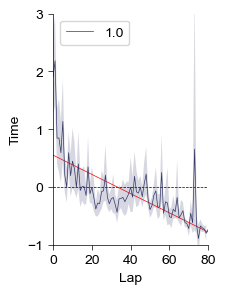

LinregressResult(slope=-0.013182407571176901, intercept=0.4357527316859196, rvalue=-0.2643120822954837, pvalue=1.0707668600963095e-26, stderr=0.001210105211382987, intercept_stderr=0.046784168806499965)


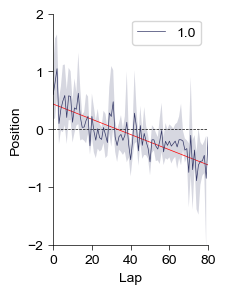

LinregressResult(slope=-0.014154936283880773, intercept=0.46968652214695283, rvalue=-0.28614822924838695, pvalue=2.284251562171657e-06, stderr=0.0029283011836940417, intercept_stderr=0.11377861285330837)
LinregressResult(slope=-0.018403209056882735, intercept=0.6016433730134738, rvalue=-0.367028223310638, pvalue=1.0345353498723156e-09, stderr=0.00290378968837335, intercept_stderr=0.11120181797690536)
LinregressResult(slope=-0.01121301232237147, intercept=0.3544901139710347, rvalue=-0.21243550575547898, pvalue=0.0006545385050784379, stderr=0.0032491316701282, intercept_stderr=0.1197509264851584)
LinregressResult(slope=-0.012270425489530926, intercept=0.40774855419173356, rvalue=-0.24714678951733063, pvalue=4.7516921129039164e-05, stderr=0.0029664751524839245, intercept_stderr=0.1152708300465491)
LinregressResult(slope=-0.013924412930598417, intercept=0.47204273650703926, rvalue=-0.28482889808977835, pvalue=1.876452260176849e-06, stderr=0.0028572242730789334, intercept_stderr=0.113127927

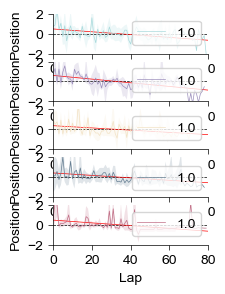

In [19]:
if exists(join(figdata, f"{code_id} [Initialization Time].pkl")) == False:

    InitData = {
        "MiceID":[],
        "Session": [],
        "Route": [],
        "Time": [],
        "Position": [],
        "Lap": [],
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        speed_thre = get_speed_thre(mouse)
        for route in range(1, 7):
            _base = 0
            for session in range(7):
                with open(join(loc, "Mapping Data", f"{mouse} R{route} S{session}.pkl"), 'rb') as f:
                    saved_data = pickle.load(f)
                    
                src_lap_traj = saved_data['lap_traj']
                src_pos_traj = saved_data['pos_traj']
                src_time_traj = saved_data['time_traj']
                src_speed_traj = saved_data['speed_traj']
                src_len_traj = saved_data['len_traj']
                targ_pos_traj = saved_data['targ_pos_traj']
                idx = saved_data['idx']
                corr_val = saved_data['corr_val']
                
                beg = np.concatenate([[0], np.where(np.ediff1d(src_lap_traj)!=0)[0]+1])
                end = np.concatenate([beg[1:], [src_lap_traj.shape[0]]])
                
                D = GetDMatrices(1, 48)
                loss = np.array([D[src_pos_traj[i], targ_pos_traj[idx][i]] for i in range(src_pos_traj.shape[0])])
    
                times = np.zeros(beg.shape[0])
                pos = np.zeros(beg.shape[0])
    
                for i in range(len(beg)):
                    loss[beg[i]:end[i]] = np.convolve(loss[beg[i]:end[i]], np.ones(10)/10, 'same')
        
                    _converge_idx = np.where(
                        (loss[beg[i]:end[i]] <= 10) &
                        (corr_val[beg[i]:end[i]] >= 0)
                    )[0]
                    
                    if _converge_idx.shape[0] == 0:
                        times[i] = src_time_traj[end[i]-1]
                        pos[i] = D[src_pos_traj[end[i]-1], SP_DSP[route]-1] / (np.max(D) + 1e-8) * 111
                    else:
                        init_pos = _converge_idx[0]
                        times[i] = src_time_traj[beg[i] + init_pos]
                        pos[i] = D[src_pos_traj[beg[i] + init_pos], SP_DSP[route]-1] / (np.max(D) + 1e-8) * 888
                        
                    InitData['MiceID'].append(mouse)
                    InitData['Session'].append(session)
                    InitData['Route'].append(route)
                    InitData['Time'].append(times[i])
                    InitData['Position'].append(pos[i])
                    InitData['Lap'].append(i + _base)
                
                _base += beg.shape[0]
    
    for key in InitData.keys():
        InitData[key] = np.array(InitData[key])
        
    with open(join(figdata, f"{code_id} [Initialization Time].pkl"), 'wb') as f:
        pickle.dump(InitData, f)
        
    print(InitData['Time'].shape)
    InitData['Time'] /= 1000
    InitD = pd.DataFrame(InitData)
    InitD.to_excel(join(figdata, f"{code_id} [Initialization Time].xlsx"), index=False)
else:
    with open(join(figdata, f"{code_id} [Initialization Time].pkl"), 'rb') as f:
        InitData = pickle.load(f)
    InitData['Time'] /= 1000

for mouse in [10212, 10224, 10227, 10232]:
    for i in range(1, 7):
        idx = np.where((InitData['Route'] == i)&(InitData['MiceID'] == mouse))[0]
        InitData['Time'][idx] = (InitData['Time'][idx] - np.mean(InitData['Time'][idx])) / np.std(InitData['Time'][idx])
        InitData['Position'][idx] = (InitData['Position'][idx] - np.mean(InitData['Position'][idx])) / np.std(InitData['Position'][idx])
    
fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(
    plt.axes(), 
    close_spines=['top', 'right'], 
    ifxticks=True, 
    ifyticks=True
)
ax.axhline(0, ls='--', linewidth=0.5, c='k')
res = linregress(InitData['Lap'], InitData['Time'])
print(res)
x = np.linspace(0, 80, 2)
ax.plot(x, x*res.slope + res.intercept, c='red', linewidth=0.5)
sns.lineplot(
    x='Lap',
    y='Time',
    data=InitData,
    hue=np.ones(InitData['Lap'].shape[0]),
    palette=[RemappingPalette[0]],
    linewidth=0.5,
    err_kws={'edgecolor': None},
)
ax.set_xlim(0, 80)
ax.set_ylim(-1, 3)
ax.set_yticks(np.linspace(-1, 3, 5))
ax.set_xticks(np.linspace(0, 80, 5))
plt.savefig(join(loc, "Time to Retrieval.png"), dpi=600)
plt.savefig(join(loc, "Time to Retrieval.svg"), dpi=600)
plt.show()

fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(
    plt.axes(), 
    close_spines=['top', 'right'], 
    ifxticks=True, 
    ifyticks=True
)
ax.axhline(0, ls='--', linewidth=0.5, c='k')
res = linregress(InitData['Lap'], InitData['Position'])
print(res)
x = np.linspace(0, 80, 2)
ax.plot(x, x*res.slope + res.intercept, c='red', linewidth=0.5)
sns.lineplot(
    x='Lap',
    y='Position',
    data=InitData,
    hue=np.ones(InitData['Lap'].shape[0]),
    palette=[RemappingPalette[0]],
    linewidth=0.5,
    err_kws={'edgecolor': None},
)
ax.set_xlim(0, 80)
ax.set_ylim(-2, 2)
ax.set_yticks(np.linspace(-2, 2, 5))
ax.set_xticks(np.linspace(0, 80, 5))
plt.savefig(join(loc, "Time Varied Position to Retrieval.png"), dpi=600)
plt.savefig(join(loc, "Time Varied Position to Retrieval.svg"), dpi=600)
plt.show()

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(2, 3))
for i, ax in enumerate(axes):
    SubData = SubDict(InitData, InitData.keys(), np.where(InitData['Route'] == [1, 2, 4, 5, 6][i])[0])
    ax = Clear_Axes(
        ax, 
        close_spines=['top', 'right'], 
        ifxticks=True, 
        ifyticks=True
    )
    ax.axhline(0, ls='--', linewidth=0.5, c='k')
    res = linregress(SubData['Lap'], SubData['Position'])
    print(res)
    x = np.linspace(0, 80, 2)
    ax.plot(x, x*res.slope + res.intercept, c='red', linewidth=0.5)
    sns.lineplot(
        x='Lap',
        y='Position',
        data=SubData,
        hue=np.ones(SubData['Lap'].shape[0]),
        palette=[DSPPalette[[1, 2, 4, 5, 6][i]]],
        linewidth=0.5,
        err_kws={'edgecolor': None},
        ax=ax
    )
    ax.set_xlim(0, 80)
    ax.set_ylim(-2, 2)
    ax.set_yticks(np.linspace(-2, 2, 3))
    ax.set_xticks(np.linspace(0, 80, 5))
    
plt.savefig(join(loc, "Time Varied Position to Retrieval.png"), dpi=600)
plt.savefig(join(loc, "Time Varied Position to Retrieval.svg"), dpi=600)
plt.show()

In [9]:
for i in range(1, 5):
    with open(f_CellReg_dsp['cellreg_folder'][i], 'rb') as handle:
        index_map = pickle.load(handle)
    index_map = index_map.astype(np.int64)
    
    if f_CellReg_dsp['MiceID'][i] != 10232:
        index_map = index_map[1:, :]
        
    index_map = index_map[:, np.where(np.sum(np.where(index_map > 0, 1, 0), axis=0) == 7)[0]]
    
    print(index_map.shape)

(7, 118)
(7, 144)
(7, 302)
(7, 261)


# Dynamics Analysis

        E:\Data\FinalResults\Dsp\0855 - Mapping Initialization Phase\Dynamic Analysis is already existed!


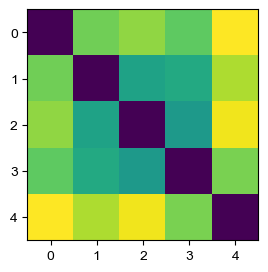

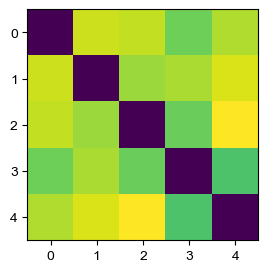

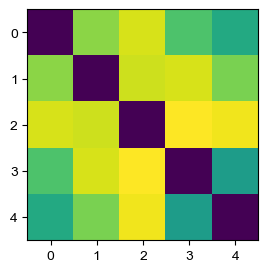

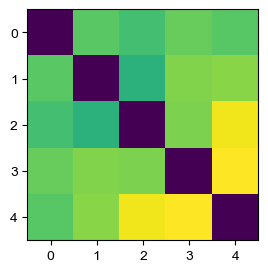

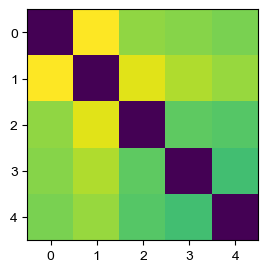

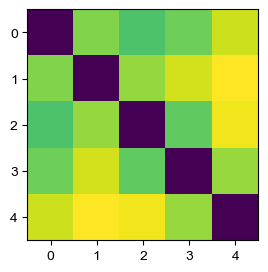

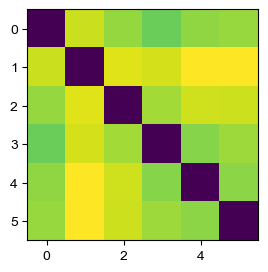

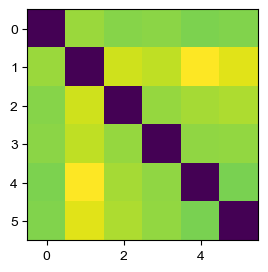

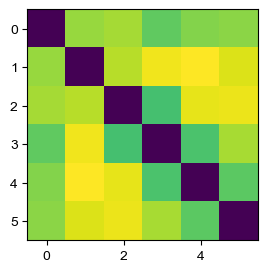

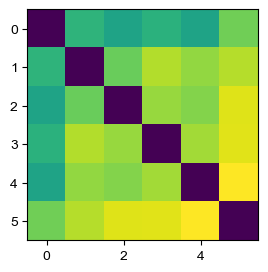

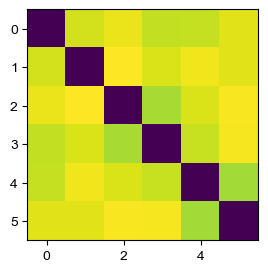

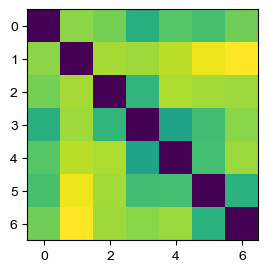

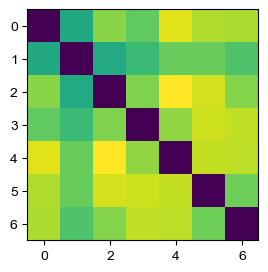

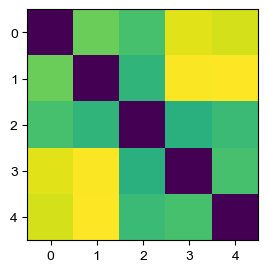

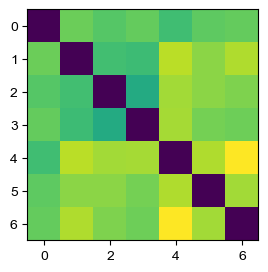

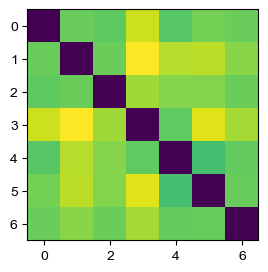

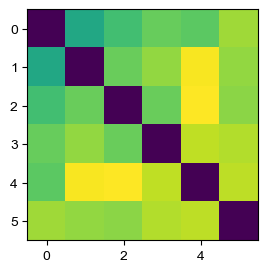

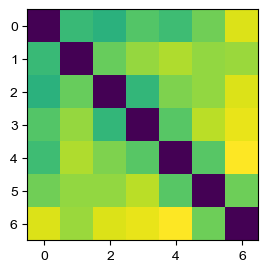

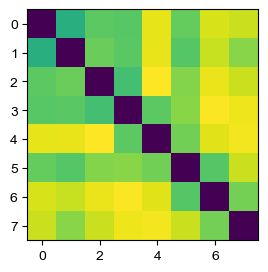

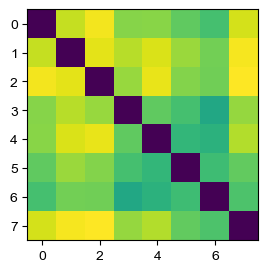

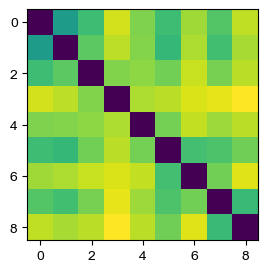

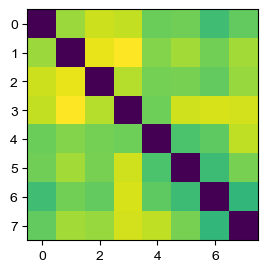

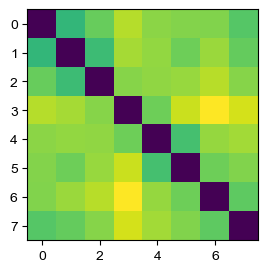

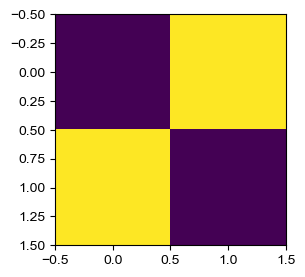

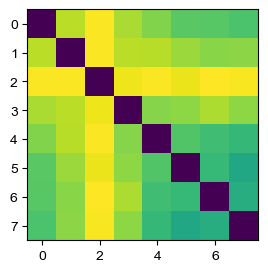

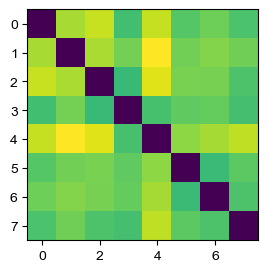

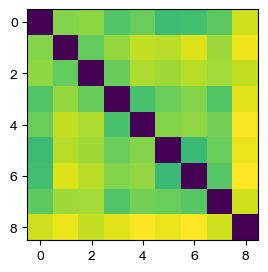

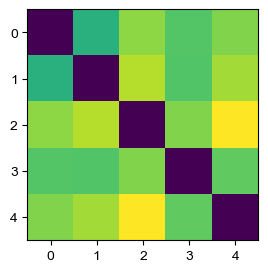

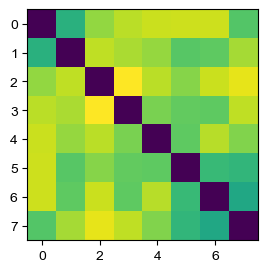

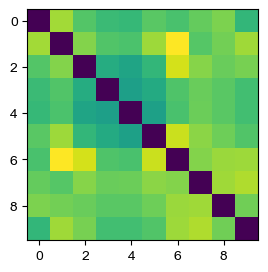

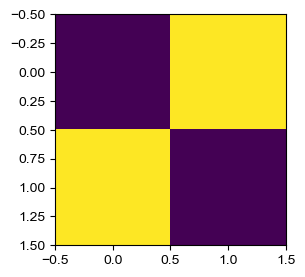

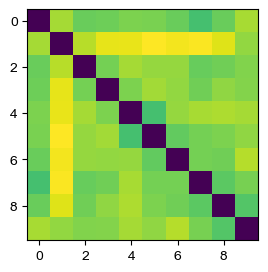

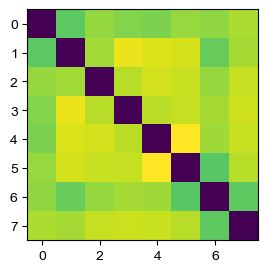

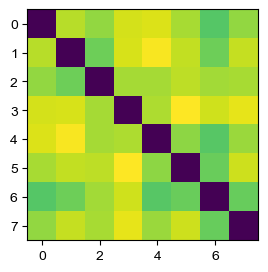

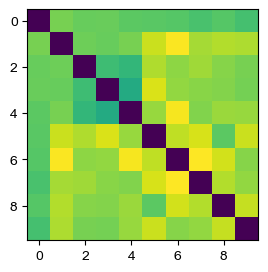

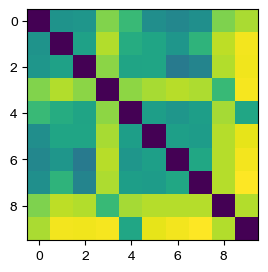

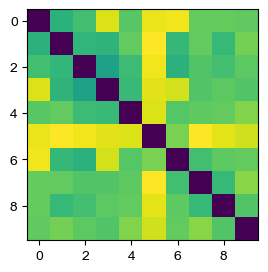

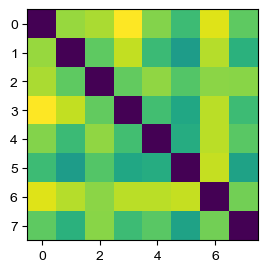

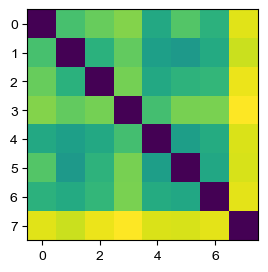

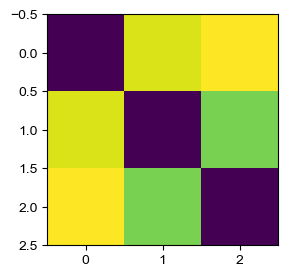

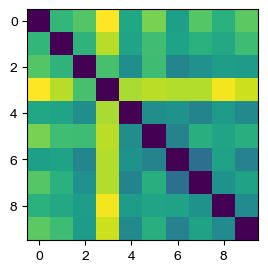

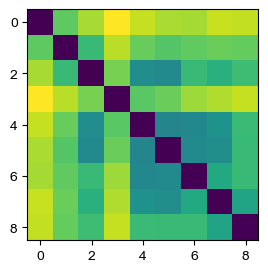

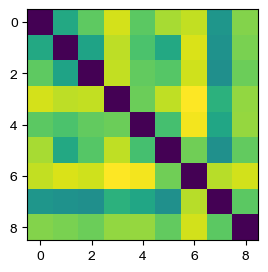

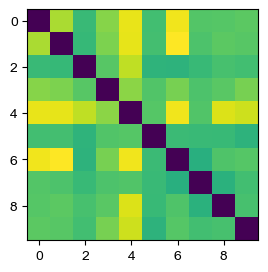

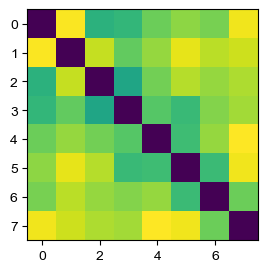

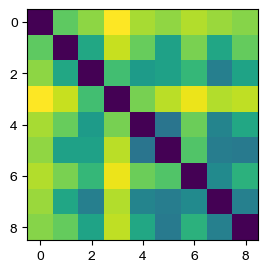

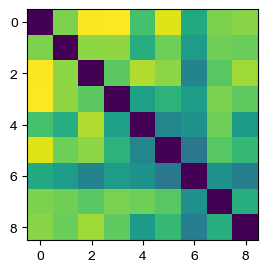

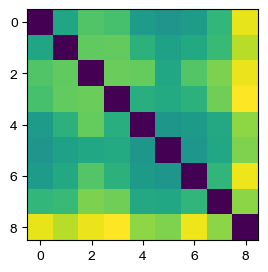

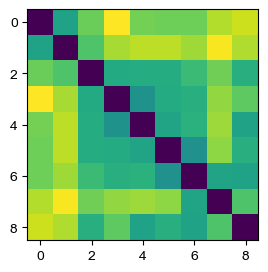

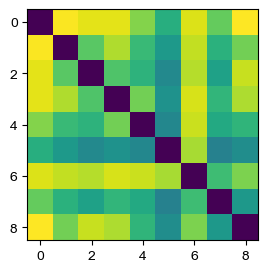

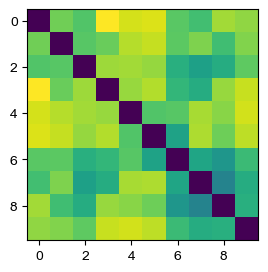

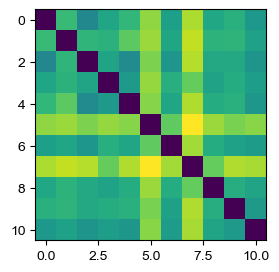

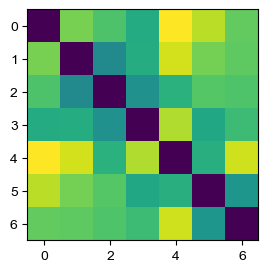

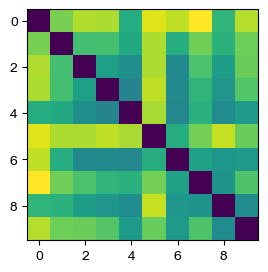

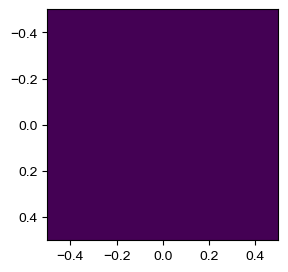

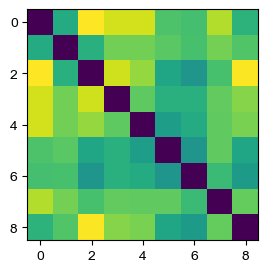

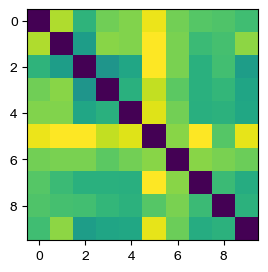

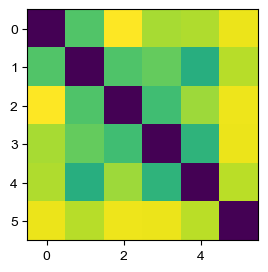

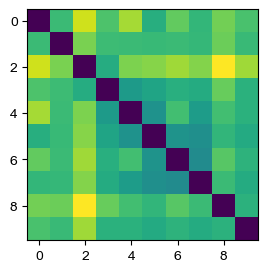

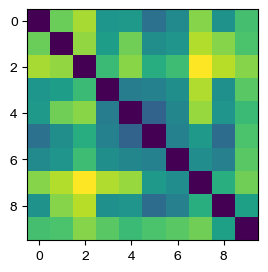

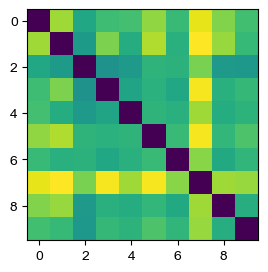

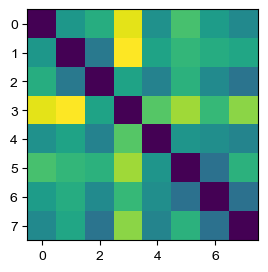

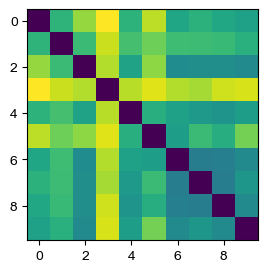

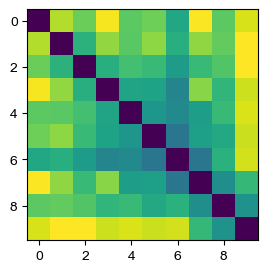

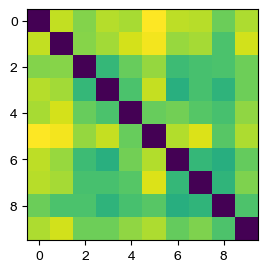

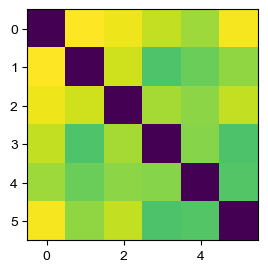

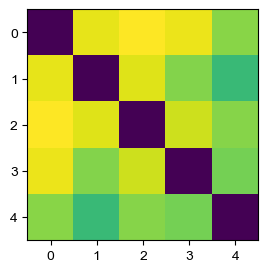

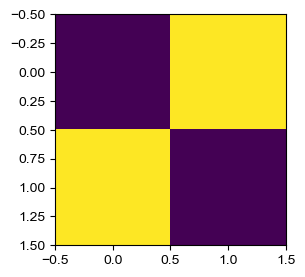

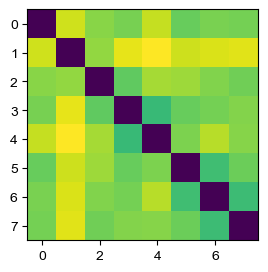

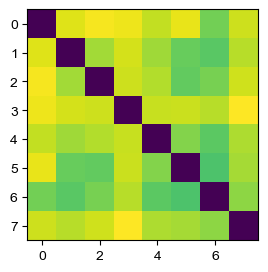

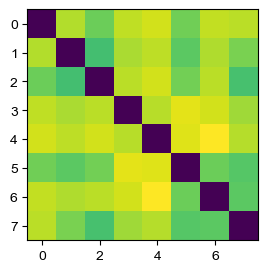

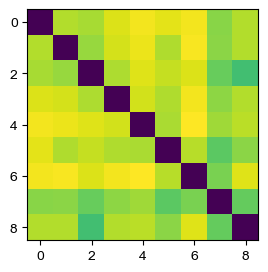

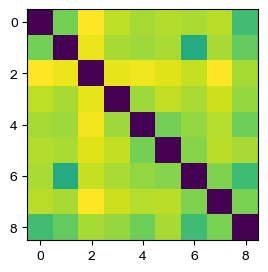

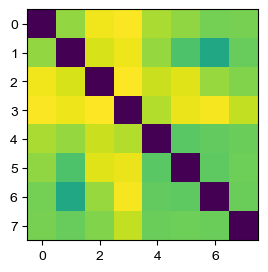

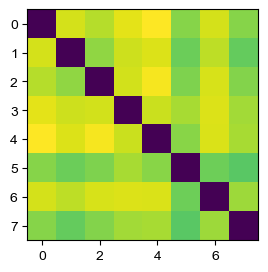

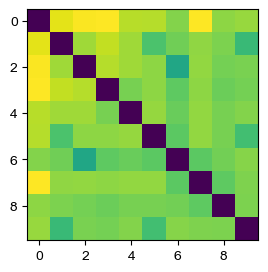

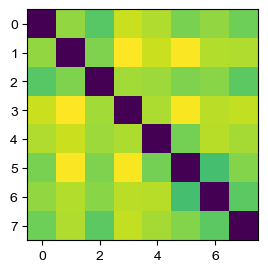

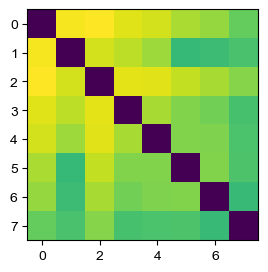

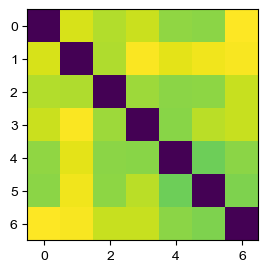

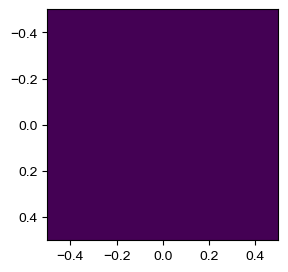

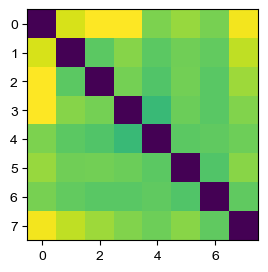

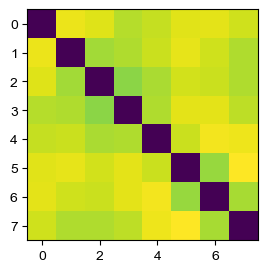

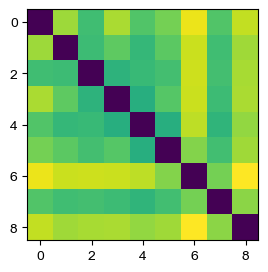

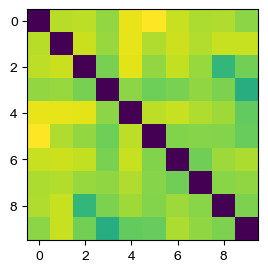

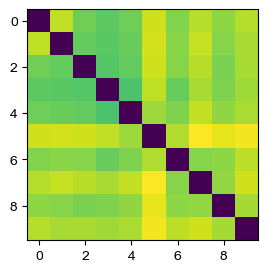

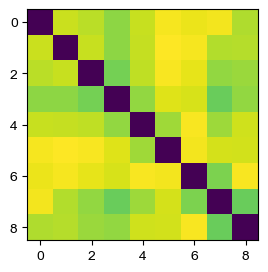

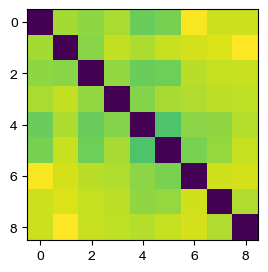

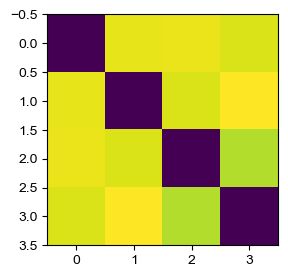

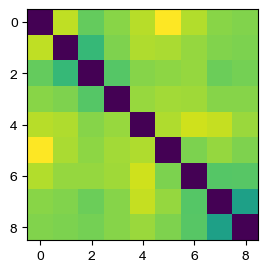

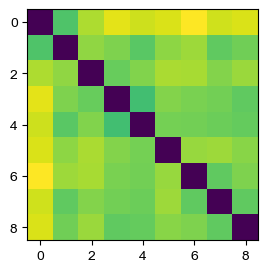

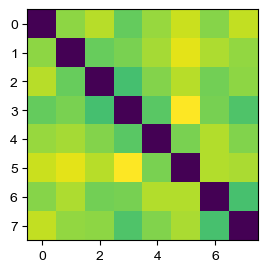

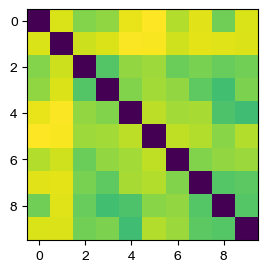

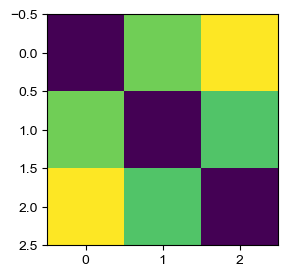

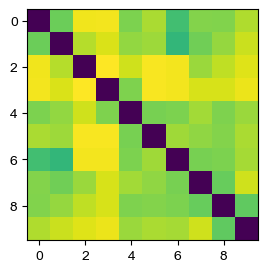

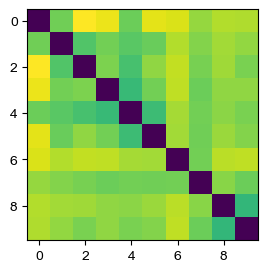

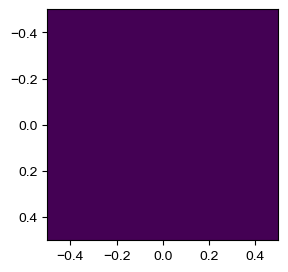

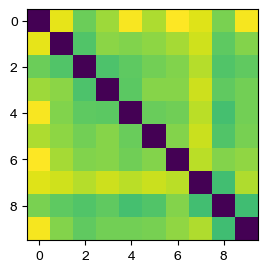

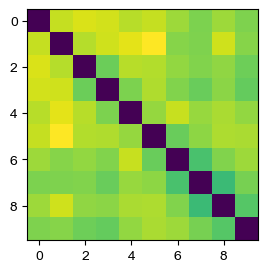

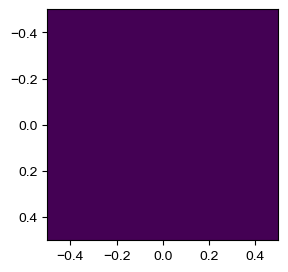

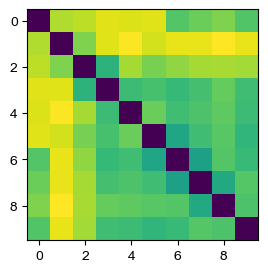

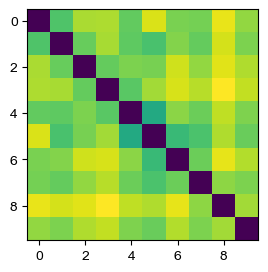

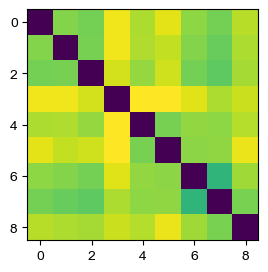

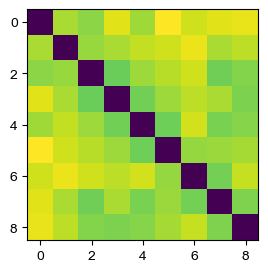

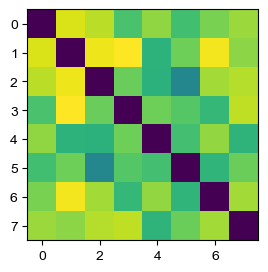

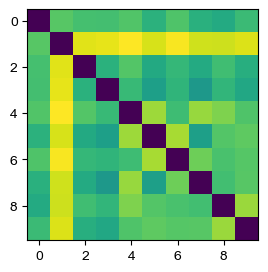

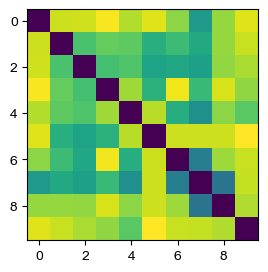

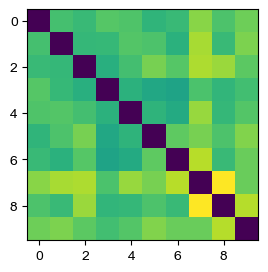

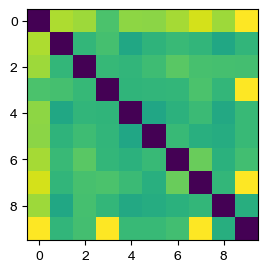

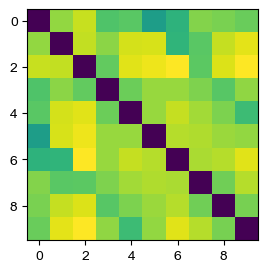

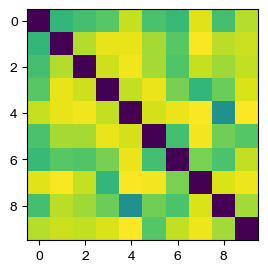

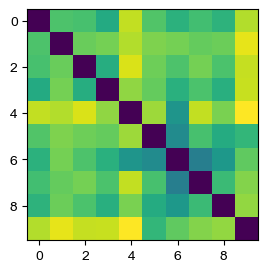

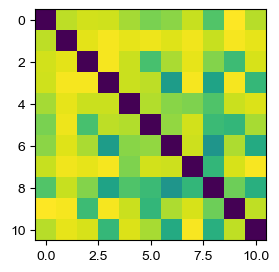

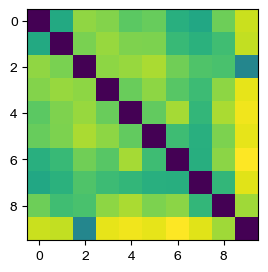

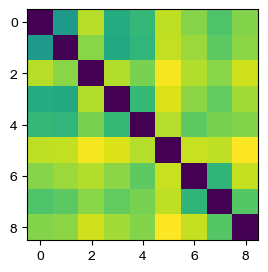

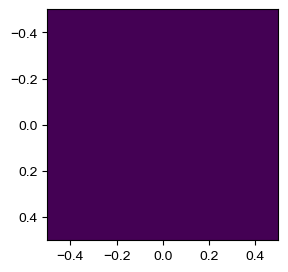

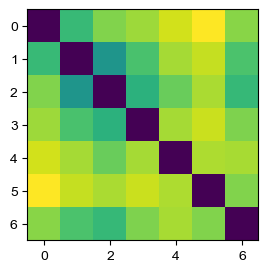

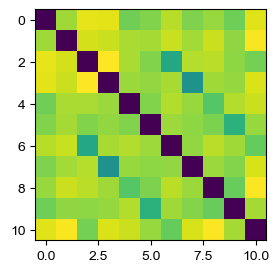

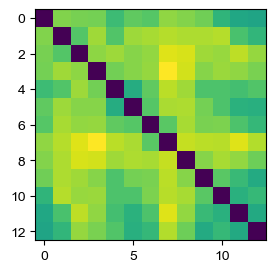

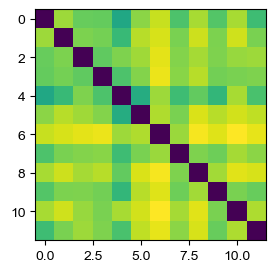

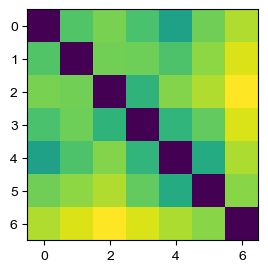

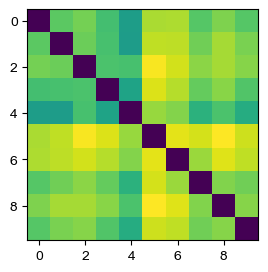

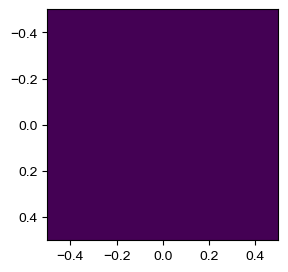

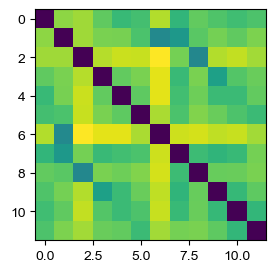

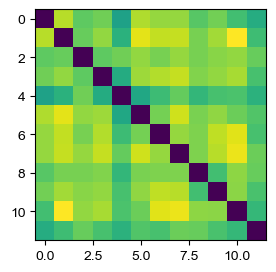

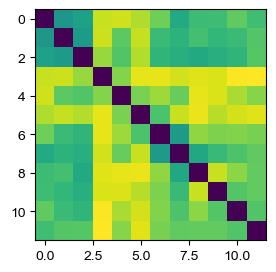

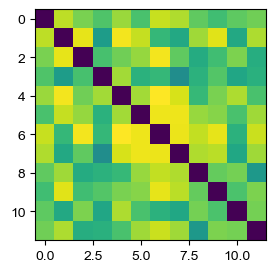

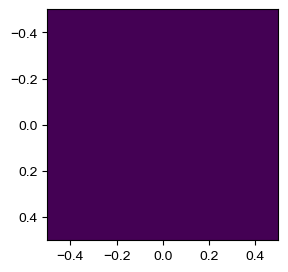

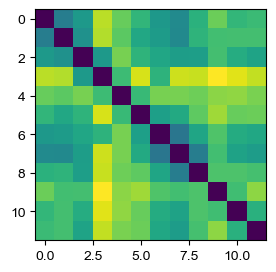

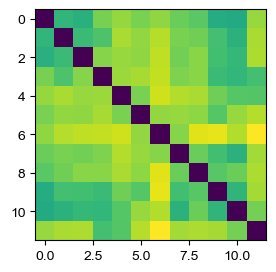

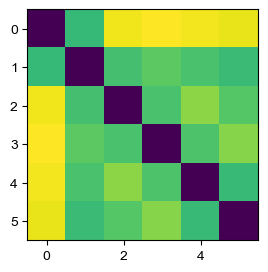

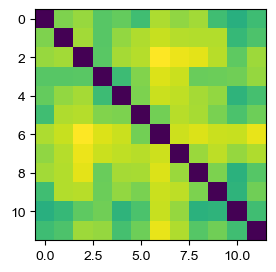

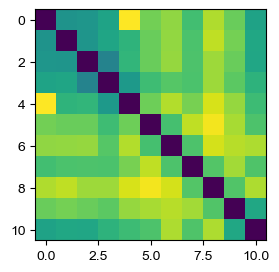

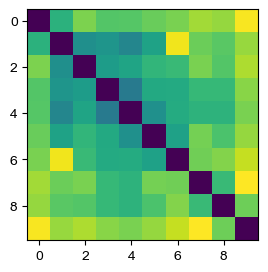

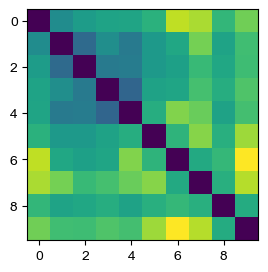

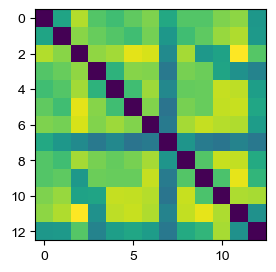

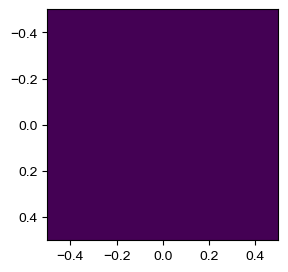

(136,)


<Axes: xlabel='Route', ylabel='Distance'>

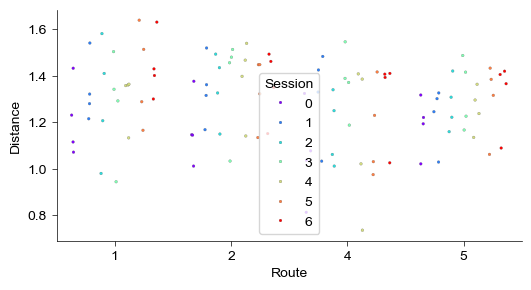

In [ ]:
dir_name = join(loc, "Dynamic Analysis")
mkdir(dir_name)

temp_bins = [
    np.array([]),
    np.array([24, 23, 22, 34, 33, 32, 44, 45, 46, 47, 48]),
    np.array([54, 66, 65,64,63, 75, 74, 62, 50, 51, 39, 38, 37, 49]),
    np.array([99, 87, 88, 76, 77, 89, 101, 102, 114, 113, 125]),
    np.array([8, 7, 6, 18, 17, 29, 30, 31, 19, 20]),
    np.array([93, 105, 106,94, 82, 81, 89, 92, 104, 103, 91, 90, 78, 79, 67, 55, 54, 66, 65, 64, 63, 75]),
    np.array([135, 134, 133, 121, 97, 109, 110, 122, 123, 111, 112, 100, 99, 87, 88, 76, 77])
]    
    
def get_init_data(mouse):
    if exists(join(dir_name, f"{mouse}.pkl")):
        with open(join(dir_name, f"{mouse}.pkl"), 'rb') as handle:
            return pickle.load(handle)
        
    print(mouse)
    neural_traj = []
    pos_traj = []
    time_traj = []
    route_traj = []
    session_traj = []
    speed_traj = []
    lap_traj = []
    len_traj = []
    retrieval_traj = []

    with open(f_CellReg_dsp['cellreg_folder'][np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]], 'rb') as handle:
        index_map = pickle.load(handle)
        
        if mouse != 10232:
            index_map = index_map[1:, :]
        
        index_map = index_map.astype(np.int64)
    
        is_cell = np.where(index_map >= 1, 1, 0)
        n_cells = np.sum(is_cell, axis=0)
        index_map = index_map[:, n_cells == 7]

    for session in range(7):
        with open(f2['Trace File'][np.where(f2['MiceID'] == mouse)[0][session]], 'rb') as handle:
            trace = pickle.load(handle)
                
        (
            neural_traj_all,
            pos_traj_all,
            _, 
            route_traj_all,
            _, speed_traj_all, _, _
        ) = get_neural_traj(trace) 
            
        for route in range(1, 7):
            with open(join(loc, "Mapping Data", f"{mouse} R{route} S{session}.pkl"), 'rb') as f:
                saved_data = pickle.load(f)
             
            src_neural_traj = saved_data['neural_traj'][index_map[session, :]-1, :]
            src_lap_traj = saved_data['lap_traj']
            src_pos_traj = saved_data['pos_traj']
            src_time_traj = saved_data['time_traj']
            src_speed_traj = saved_data['speed_traj']
            src_len_traj = saved_data['len_traj']
            targ_pos_traj = saved_data['targ_pos_traj']
            idx = saved_data['idx']
            corr_val = saved_data['corr_val']
            
            beg = np.concatenate([[0], np.where(np.ediff1d(src_lap_traj)!=0)[0]+1])
            end = np.concatenate([beg[1:], [src_lap_traj.shape[0]]])
            
            D = GetDMatrices(1, 48)
            loss = np.array([D[src_pos_traj[i], targ_pos_traj[idx][i]] for i in range(src_pos_traj.shape[0])])
    
            times = np.zeros(beg.shape[0])
    
            for i in range(len(beg)):
                loss[beg[i]:end[i]] = np.convolve(loss[beg[i]:end[i]], np.ones(10)/10, 'same')
        
                _converge_idx = np.where(
                    (loss[beg[i]:end[i]] <= 10) &
                    (corr_val[beg[i]:end[i]] >= 0.1)
                )[0]
                
                if _converge_idx.shape[0] == 0:
                    continue
                else:
                    init_pos = _converge_idx[0]
                    
                    neural_traj.append(src_neural_traj[:, beg[i]:beg[i] + init_pos])
                    pos_traj.append(src_pos_traj[beg[i]:beg[i] + init_pos])
                    time_traj.append(src_time_traj[beg[i]:beg[i] + init_pos])
                    route_traj.append(np.repeat(route, init_pos))
                    session_traj.append(np.repeat(session, init_pos))
                    speed_traj.append(src_speed_traj[beg[i]:beg[i] + init_pos])
                    lap_traj.append(np.repeat(i, init_pos))
                    len_traj.append(src_len_traj[beg[i]:beg[i] + init_pos])
                    retrieval_traj.append(np.repeat(0, init_pos))
                    
                    neural_traj.append(src_neural_traj[:, beg[i] + _converge_idx])
                    pos_traj.append(src_pos_traj[beg[i] + _converge_idx])
                    time_traj.append(src_time_traj[beg[i] + _converge_idx])
                    route_traj.append(np.repeat(route, _converge_idx.shape[0]))
                    session_traj.append(np.repeat(session, _converge_idx.shape[0]))
                    speed_traj.append(src_speed_traj[beg[i] + _converge_idx])
                    lap_traj.append(np.repeat(i, _converge_idx.shape[0]))
                    len_traj.append(src_len_traj[beg[i] + _converge_idx])
                    retrieval_traj.append(np.repeat(1, _converge_idx.shape[0]))
        
        
        route1_idx = np.where(route_traj_all == 0)[0]
        neural_traj.append(neural_traj_all[:, route1_idx][index_map[session, :]-1, :])
        pos_traj.append(pos_traj_all[route1_idx])
        time_traj.append(np.ones_like(route1_idx))
        route_traj.append(np.zeros_like(route1_idx))
        session_traj.append(np.zeros_like(route1_idx)+session)
        speed_traj.append(speed_traj_all[route1_idx])
        lap_traj.append(np.ones_like(route1_idx)-2)
        len_traj.append(np.ones_like(route1_idx)-2)
        retrieval_traj.append(np.ones_like(route1_idx))
            
    neural_traj = np.concatenate(neural_traj, axis=1)
    pos_traj = np.concatenate(pos_traj)
    time_traj = np.concatenate(time_traj)
    route_traj = np.concatenate(route_traj)
    session_traj = np.concatenate(session_traj)
    speed_traj = np.concatenate(speed_traj)
    lap_traj = np.concatenate(lap_traj)
    len_traj = np.concatenate(len_traj)
    retrieval_traj = np.concatenate(retrieval_traj)
    
    with open(join(dir_name, f"{mouse}.pkl"), 'wb') as handle:
        pickle.dump((
            neural_traj,
            pos_traj.astype(np.int64),
            time_traj.astype(np.int64),
            route_traj.astype(np.int64),
            session_traj.astype(np.int64),
            speed_traj,
            lap_traj.astype(np.int64),
            len_traj,
            retrieval_traj.astype(np.int64)
        ), handle)
        
    return (
        neural_traj,
        pos_traj.astype(np.int64),
        time_traj.astype(np.int64),
        route_traj.astype(np.int64),
        session_traj.astype(np.int64),
        speed_traj,
        lap_traj.astype(np.int64),
        len_traj,
        retrieval_traj.astype(np.int64)
    )

from scipy.spatial.distance import cdist

def compute_nearest_neighbor_distance(trajectory_1, trajectory_2):
    """
    Compute the distance between two neural trajectories by finding the nearest points in the longer trajectory for each point in the shorter trajectory.
    
    Parameters:
    - trajectory_1: N x T1 matrix, where N is the number of neurons and T1 is the number of time steps
    - trajectory_2: N x T2 matrix, where N is the number of neurons and T2 is the number of time steps
    
    Returns:
    - average_distance: Average Euclidean distance between the nearest point pairs from both trajectories
    """
    # Determine which trajectory is shorter
    if trajectory_1.shape[1] <= trajectory_2.shape[1]:
        shorter_trajectory, longer_trajectory = trajectory_1, trajectory_2
    else:
        shorter_trajectory, longer_trajectory = trajectory_2, trajectory_1
    
    # Compute the pairwise distances between each point in the shorter trajectory and all points in the longer trajectory
    distances = cdist(shorter_trajectory.T, longer_trajectory.T, metric='euclidean')  # T x T pairwise distances
    
    # For each point in the shorter trajectory, find the minimum distance to any point in the longer trajectory
    min_distances = np.min(distances, axis=1)
    
    # Compute the average of these minimum distances
    average_distance = np.mean(min_distances)
    
    return average_distance

if exists(join(figdata, f"{code_id}  [Trajectory Distances].pkl")) == False:
    
    TDData = {
        "MiceID":[],
        "Session": [],
        "Route": [],
        "Distance": []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        (
            neural_traj,
            pos_traj,
            time_traj,
            route_traj,
            session_traj,
            speed_traj,
            lap_traj,
            len_traj,
            retrieval_traj
        ) = get_init_data(mouse=mouse)
        
        peak_rates = np.percentile(neural_traj, 90, axis=1)
        neural_traj_norm = np.zeros(neural_traj.shape)
        for i in range(neural_traj.shape[0]):
            if peak_rates[i] > 0:
                neural_traj_norm[i, :] = np.clip(neural_traj[i, :] / peak_rates[i], 0, 1)
        
        for s in range(7):
            for r in range(1, 7):
                idx = np.where((session_traj == s) & (route_traj == r) & (retrieval_traj == 0))[0]
                
                if len(idx) == 0:
                    continue
                
                beg = np.concatenate([[0], np.where(np.ediff1d(lap_traj[idx])!=0)[0]+1])
                end = np.concatenate([np.where(np.ediff1d(lap_traj[idx])!=0)[0]+1, [len(lap_traj[idx])]])
                
                distances = np.zeros((beg.shape[0], beg.shape[0]))
                
                for i in range(beg.shape[0]-1):
                    for j in range(i+1, beg.shape[0]):
                        distances[i, j] = compute_nearest_neighbor_distance(neural_traj[:, beg[i]:end[i]], neural_traj[:, beg[j]:end[j]])
                        distances[j, i] = distances[i, j]
                
                mean_dist = np.mean(distances)
                TDData["MiceID"].append(mouse)
                TDData["Session"].append(s)
                TDData["Route"].append(r)
                TDData["Distance"].append(mean_dist/np.sqrt(neural_traj.shape[0]))
    
    for k in TDData.keys():
        TDData[k] = np.array(TDData[k])
    
    with open(join(figdata, f"{code_id} [Trajectory Distances].pkl"), 'wb') as handle:
        pickle.dump(TDData, handle)
        
    TDD = pd.DataFrame(TDData)
    TDD.to_excel(join(figdata, f"{code_id} [Trajectory Distances].xlsx"), index=False)
    print(TDData["Distance"].shape)
else:
    with open(join(figdata, f"{code_id} [Trajectory Distances].pkl"), 'rb') as handle:
        TDData = pickle.load(handle)

idx = np.where(np.isin(TDData['Route'], [1, 2, 4, 5]))[0]
SubData = SubDict(TDData, TDData.keys(), idx)
fig = plt.figure(figsize=(6, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)               
sns.stripplot(
    x="Route",
    y="Distance",
    data=SubData,
    hue="Session",
    palette='rainbow',
    size=2, 
    linewidth=0.15,
    dodge=True,
    jitter=0.2,
) 

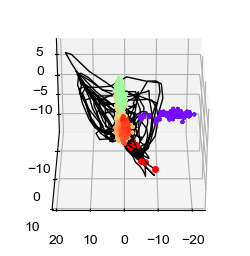

In [103]:
(
    neural_traj,
    pos_traj,
    time_traj,
    route_traj,
    session_traj,
    speed_traj,
    lap_traj,
    len_traj,
    retrieval_traj
) = get_init_data(mouse=10232)

idx0 = np.where((session_traj == 6) & (np.isin(route_traj, [0, 5]) & (np.isin(S2F[pos_traj], temp_bins[5]))))[0]
idx1 = np.where((session_traj == 6) & (np.isin(route_traj, [5]) & (np.isin(S2F[pos_traj], temp_bins[5]))))[0]
idx2 = np.where(np.isin(route_traj[idx0], [0]))[0]
 
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from umap.umap_ import UMAP

model = PCA(n_components=30)
denoised_data = model.fit_transform(neural_traj[:, idx0].T)
lda = LDA(n_components=3)
red_data = lda.fit_transform(denoised_data, pos_traj[idx0])
#umap_model = UMAP(n_components=10)
#red_data = umap_model.fit_transform(red_data)
D = GetDMatrices(1, 48)


vmax, vmin = np.max(D[pos_traj[idx0], 2303]), np.min(D[pos_traj[idx0], 2303])

beg = np.concatenate([[0], np.where(np.ediff1d(lap_traj[idx1])!=0)[0]+1])
end = np.concatenate([np.where(np.ediff1d(lap_traj[idx1])!=0)[0]+1, [len(lap_traj[idx1])]])

colors = sns.color_palette("Spectral", len(beg))
fig = plt.figure(figsize=(3, 3))
ax = Clear_Axes(fig.add_subplot(projection='3d'), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
for i in range(beg.shape[0]):
    res = model.transform(neural_traj[:, idx1[beg[i]:end[i]]].T)

    ax.scatter(
        red_data[idx2, 0],
        red_data[idx2, 1],
        red_data[idx2, 2],
        s=3,
        edgecolors=None,
        c=sns.color_palette("rainbow", as_cmap=True)((D[pos_traj[idx0][idx2], 2303] - vmin) /(vmax - vmin + 1e-8)),
    )
    ax.plot(
        res[:, 0],
        res[:, 1],
        res[:, 2],
        lw=1,
        c='k'
    )
    ax.plot(
        [res[0, 0]],
        [res[0, 1]],
        [res[0, 2]],
        'o',
        c='r',
        markersize=5,
        markeredgewidth=0
    )
    ax.plot(
        [res[-1, 0]],
        [res[-1, 1]],
        [res[-1, 2]],
        '^',
        c='k',
        markersize=5,
        markeredgewidth=0
    )
ax.azim = 90
ax.elev = 30
plt.show()

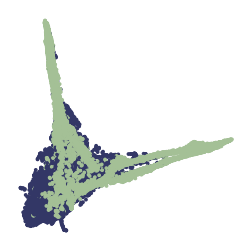

In [35]:
fig = plt.figure(figsize=(3, 3))
ax = Clear_Axes(plt.axes())
ax.scatter(
    red_data[:, 1],#[idx, 0],
    red_data[:, 2],#[idx, 1],
    s=3,
    edgecolors=None,
    c=MAPPaletteRGBA[retrieval_traj, :],#[retrieval_traj[idx], :]
)
ax.azim = 90
ax.elev = 2